In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Datos

In [2]:
# Rutas de TP
datos = "../datos"
rutas_json = f"{datos}/rutas_merida_geo/rutas_merida.geojson"
rutas = gpd.read_file(rutas_json)
rutas.head(2)

,shape_id,route_id,geometry
0,1070D-1,1070,"LINESTRING (-89.67631 20.99132, -89.67676 20.9..."
1,1071D-1,1071,"LINESTRING (-89.67619 20.9904, -89.67518 20.99..."


In [7]:
# Isocronas
t = 10
isocronas_pob_gpkg = f"{datos}/isocronas_mza_pob_merida_2020.gpkg"
iso = gpd.read_file(isocronas_pob_gpkg, encoding='utf-8', layer=f"{t}_minutos_pob", columns=['CVEGEO', 'geometry'])
iso.head(2)

,CVEGEO,geometry
0,3101300010080014,"POLYGON ((-89.52058 21.07342, -89.51783 21.070..."
1,3101300010080022,"POLYGON ((-89.51322 21.07246, -89.51248 21.069..."


In [4]:
# Manzanas INEGI
bbox_merida = 3764086,1034675,3792830,1069982
manzanas_shp = f"{datos}/31_Manzanas_INV2020_shp/INV2020_IND_PVEU_MZA_31.shp"
manz = gpd.read_file(manzanas_shp, encoding='utf-8', bbox=bbox_merida)\
    .to_crs(epsg=4326)
manz["POBTOT"] = manz["POBTOT"].astype(int)
manz.head(2)

,CVEGEO,CVE_ENT,NOM_ENT,CVE_MUN,NOM_MUN,CVE_LOC,NOM_LOC,CVE_AGEB,CVE_MZA,AMBITO,...,DRENAJEP_D,TRANSCOL_D,ACESOPER_D,ACESOAUT_D,PUESSEMI_D,PUESAMBU_D,FECHA_POLI,FECHA_INF,FECHA_CEU,geometry
0,3101300010095034,31,Yucatán,013,Conkal,0001,Conkal,0095,034,Urbana,...,Alguna vialidad,Ninguna vialidad,Restricción en ninguna vialidad,Restricción en ninguna vialidad,Ninguna vialidad,Ninguna vialidad,2020,2020,2020,"POLYGON ((-89.51199 21.07117, -89.512 21.07111..."
1,3101300010131016,31,Yucatán,013,Conkal,0001,Conkal,0131,016,Urbana,...,Ninguna vialidad,Ninguna vialidad,Restricción en ninguna vialidad,Restricción en ninguna vialidad,Ninguna vialidad,Ninguna vialidad,2020,2020,2020,"POLYGON ((-89.53608 21.05312, -89.53746 21.054..."


# Número de rutas por manzanas

In [8]:
# Calcula el número de rutas de TP en cada manzana
rutas_tp_10_w = gpd.sjoin(
    iso[["CVEGEO", "geometry"]],
    rutas[["geometry"]],
    how='left', predicate='intersects'
    )["CVEGEO"].value_counts()\
    .rename("rutas_tp_10w")

manz_tp_10w = manz.set_index("CVEGEO")[["geometry", "POBTOT"]]\
    .join(rutas_tp_10_w)\
    .assign(rutas_tp_10w_pob=lambda x: x["rutas_tp_10w"].div(x["POBTOT"]).mul(100))

manz_tp_10w.loc[lambda x: x["POBTOT"]==0, "rutas_tp_10w_pob"] = 0
manz_tp_10w.head(2)

,geometry,POBTOT,rutas_tp_10w,rutas_tp_10w_pob
CVEGEO,,,,
3101300010095034,"POLYGON ((-89.51199 21.07117, -89.512 21.07111...",55,2.0,3.636364
3101300010131016,"POLYGON ((-89.53608 21.05312, -89.53746 21.054...",31,2.0,6.451613


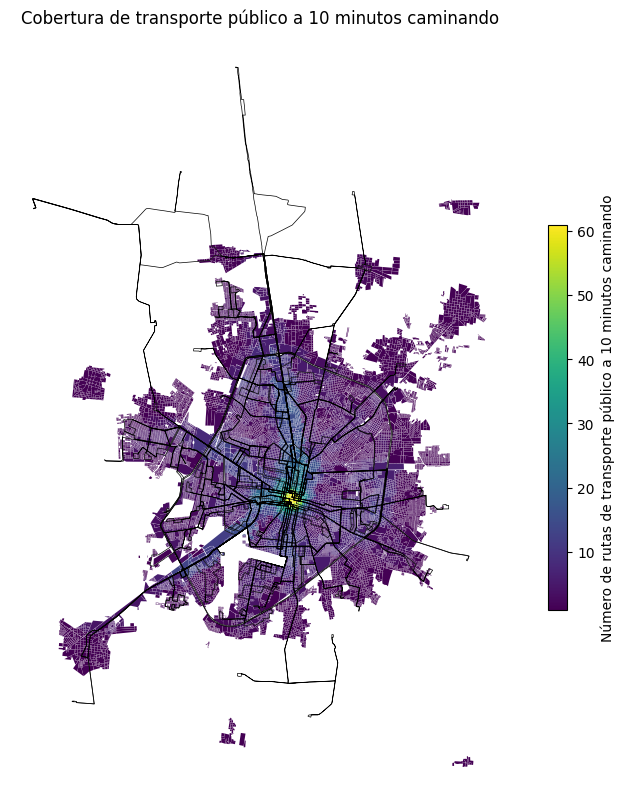

In [9]:
# Grafica de manzanas con cobertura de TP a 10 minutos
ax = manz_tp_10w.plot(column="rutas_tp_10w",
                      figsize=(10, 10),
                      legend=True,
                      legend_kwds={"label": "Número de rutas de transporte público a 10 minutos caminando",
                                   "shrink": 0.5},)
rutas.plot(ax=ax, color="k", linewidth=0.5)
ax.set_title("Cobertura de transporte público a 10 minutos caminando")
ax.set_axis_off()

In [10]:
# manz_tp_10w.explore(column="rutas_tp_10w")

In [11]:
# Grafica de manzanas con cobertura de TP a 10 minutos como proporcion de la población
#manz_tp_10w.query("rutas_tp_10w_pob<100").plot(column="rutas_tp_10w_pob", figsize=(10, 10), legend=True)

# Población atendida por rutas

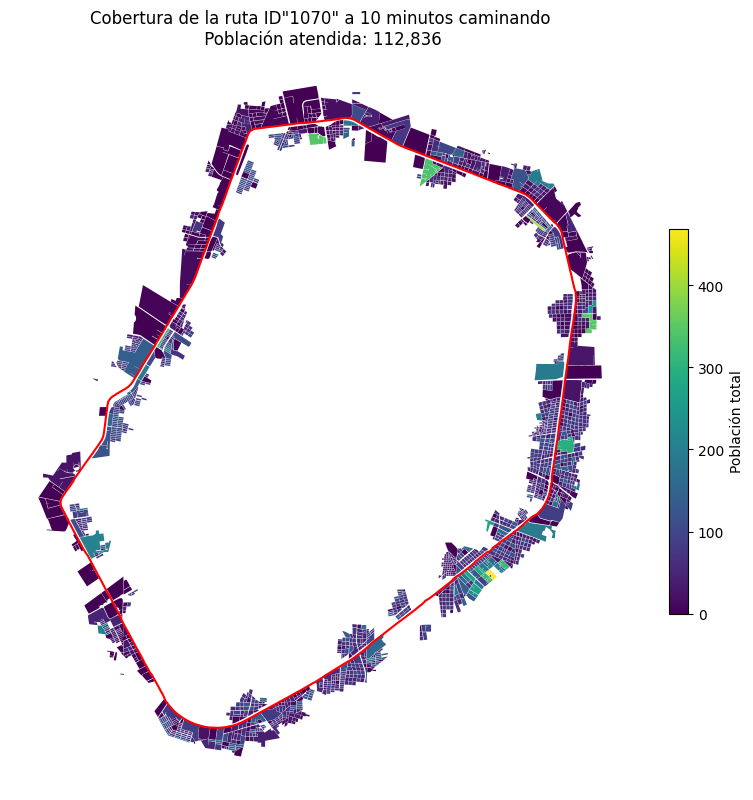

In [19]:
i = 0
ruta_i = rutas.loc[i, "geometry"]
mzas_ruta_iso = iso.loc[iso.intersects(ruta_i), "CVEGEO"].unique().tolist()
mzas_ruta = manz.set_index("CVEGEO").loc[mzas_ruta_iso]
ax = mzas_ruta.plot(column="POBTOT", figsize=(10, 10),
                    legend=True,
                    legend_kwds={"label": "Población total", "shrink": 0.5})
rutas.loc[[i]].plot(ax=ax, color="r")
ax.set_title(f"Cobertura de la ruta ID\"{rutas.loc[i, 'route_id']}\" a 10 minutos caminando\n Población atendida: {mzas_ruta['POBTOT'].sum():,}")
ax.set_axis_off()

In [16]:
rutas.head(2)

,shape_id,route_id,geometry
0,1070D-1,1070,"LINESTRING (-89.67631 20.99132, -89.67676 20.9..."
1,1071D-1,1071,"LINESTRING (-89.67619 20.9904, -89.67518 20.99..."
